## Import Libraries and Configuration

In [1]:
import os
import time
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# --- Configuration ---
DATASET_DIR = "../Rust_Dataset"
IMG_HEIGHT, IMG_WIDTH = 640, 640
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 4
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

## Helper Functions

In [3]:
def force_print(msg):
    print(msg, flush=True)

In [4]:
def calculate_code_metrics():
    try:
        import radon.complexity as cc
        import radon.metrics as mi
        # For notebook, we'll skip file reading and return placeholder values
        return 0, 0
    except ImportError:
        return 0, 0

In [5]:
def calculate_map(model, dataloader, device):
    try:
        from sklearn.metrics import average_precision_score
        from sklearn.preprocessing import label_binarize
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                # SqueezeNet output might need flattening depending on version, 
                # but standard torchvision model outputs (Batch, Num_Classes)
                outputs = torch.softmax(outputs, dim=1)
                all_preds.append(outputs.cpu().numpy())
                all_labels.append(labels.numpy())
        if not all_labels: return 0.0
        y_pred_probs = np.concatenate(all_preds)
        y_true = np.concatenate(all_labels)
        y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
        return average_precision_score(y_true_bin, y_pred_probs, average="macro")
    except ImportError:
        return 0.0

## Check Dataset and Device

In [6]:
force_print(f"--- Starting SqueezeNet 1.1 Training & Analysis ---")

if not os.path.exists(os.path.join(DATASET_DIR, 'train')):
    force_print(f"ERROR: Could not find dataset at '{os.path.abspath(DATASET_DIR)}'")
else:
    force_print("Dataset found!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
force_print(f"Using device: {device}")

--- Starting SqueezeNet 1.1 Training & Analysis ---
Dataset found!
Using device: cuda
Dataset found!
Using device: cuda


## Data Preparation

In [7]:
# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}

In [8]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET_DIR, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x == 'train'), num_workers=0)
               for x in ['train', 'valid']}

test_loader = DataLoader(image_datasets['test'], batch_size=1, shuffle=False, num_workers=0)
force_print(f"Data loaded. Train images: {len(image_datasets['train'])}")

Data loaded. Train images: 438


In [9]:
# Print tensor sizes
sample_input, _ = next(iter(dataloaders['train']))
print(f"Sample input tensor size: {sample_input.size()}")

Sample input tensor size: torch.Size([16, 3, 640, 640])


## Model Setup

In [10]:
# Model Construction (SqueezeNet 1.1)
force_print("Downloading/Loading Model...")
model = models.squeezenet1_1(weights='IMAGENET1K_V1')

# Freeze feature layers
for param in model.features.parameters():
    param.requires_grad = False
    
# --- SQUEEZENET SPECIFIC MODIFICATION ---
# SqueezeNet uses a "Final Conv Layer" instead of a Linear Layer.
# The classifier is a Sequential block: 
# [0] Dropout, [1] Conv2d(512, 1000), [2] ReLU, [3] AvgPool
# We must replace layer [1].

model.classifier[1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1,1), stride=(1,1))

# Note: We must initialize weights for this new layer or it will train very slowly
nn.init.kaiming_uniform_(model.classifier[1].weight)
if model.classifier[1].bias is not None:
    nn.init.constant_(model.classifier[1].bias, 0)

model = model.to(device)
force_print("Model loaded and configured!")

Downloading/Loading Model...
Model loaded and configured!
Model loaded and configured!


In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# We optimize only the classifier parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

## Training Loop

In [12]:
force_print("Starting Training Loop...")

# Lists to store training history
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if i % 5 == 0:
            print(f"\rEpoch {epoch+1} - Batch {i}/{len(dataloaders['train'])}...", end="", flush=True)

    epoch_train_loss = running_loss / len(image_datasets['train'])
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloaders['valid']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_valid_loss = running_loss / len(image_datasets['valid'])
    epoch_valid_acc = correct / total
    valid_losses.append(epoch_valid_loss)
    valid_accs.append(epoch_valid_acc)
    
    force_print(f"\nEpoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f}")

Starting Training Loop...
Epoch 1 - Batch 0/28...

c:\4 - CODING FILES\SOFTWARE-DESIGN1\.venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1 - Batch 25/28...
Epoch 1/30 - Train Loss: 1.9141, Train Acc: 0.3059, Valid Loss: 2.2611, Valid Acc: 0.2358

Epoch 1/30 - Train Loss: 1.9141, Train Acc: 0.3059, Valid Loss: 2.2611, Valid Acc: 0.2358
Epoch 2 - Batch 25/28...
Epoch 2/30 - Train Loss: 1.6491, Train Acc: 0.3425, Valid Loss: 1.9959, Valid Acc: 0.2764

Epoch 2/30 - Train Loss: 1.6491, Train Acc: 0.3425, Valid Loss: 1.9959, Valid Acc: 0.2764
Epoch 3 - Batch 25/28...
Epoch 3/30 - Train Loss: 1.5350, Train Acc: 0.3425, Valid Loss: 1.8121, Valid Acc: 0.3089

Epoch 3/30 - Train Loss: 1.5350, Train Acc: 0.3425, Valid Loss: 1.8121, Valid Acc: 0.3089
Epoch 4 - Batch 25/28...
Epoch 4/30 - Train Loss: 1.4251, Train Acc: 0.3904, Valid Loss: 1.6890, Valid Acc: 0.3089

Epoch 4/30 - Train Loss: 1.4251, Train Acc: 0.3904, Valid Loss: 1.6890, Valid Acc: 0.3089
Epoch 5 - Batch 25/28...
Epoch 5/30 - Train Loss: 1.3206, Train Acc: 0.4087, Valid Loss: 1.5823, Valid Acc: 0.3252

Epoch 5/30 - Train Loss: 1.3206, Train Acc: 0.4087, Valid Lo

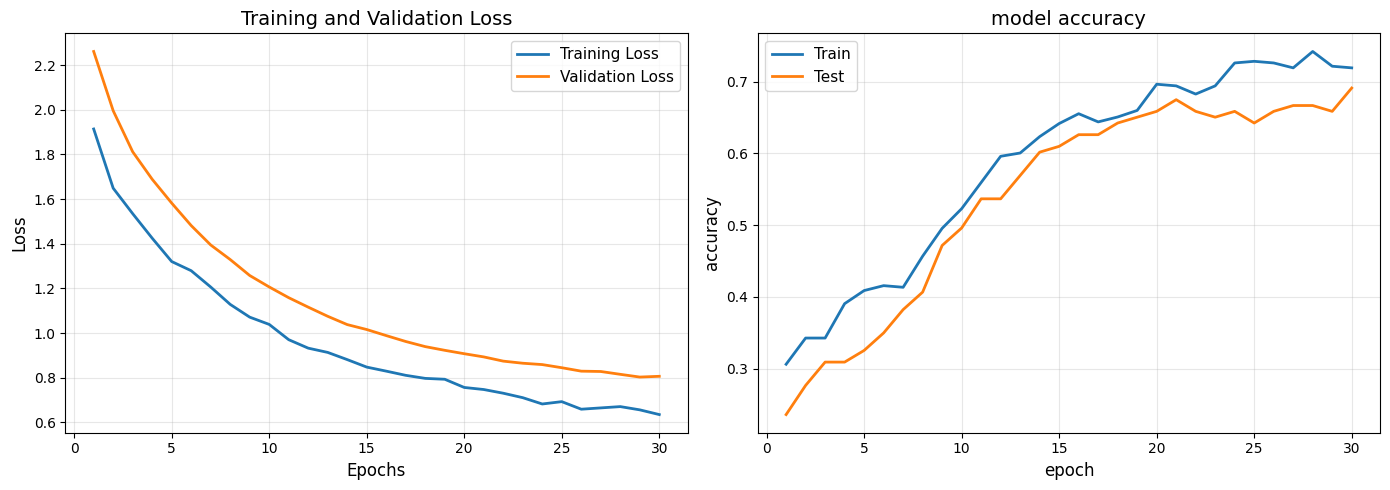


Final Train Loss: 0.6354 - Train Accuracy: 0.7192
Final Valid Loss: 0.8068 - Valid Accuracy: 0.6911
Final Valid Loss: 0.8068 - Valid Accuracy: 0.6911


In [13]:
# Visualize training history with matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss over epochs
epochs_range = range(1, EPOCHS + 1)
ax1.plot(epochs_range, train_losses, linewidth=2, label='Training Loss', color='#1f77b4')
ax1.plot(epochs_range, valid_losses, linewidth=2, label='Validation Loss', color='#ff7f0e')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot Accuracy over epochs
ax2.plot(epochs_range, train_accs, linewidth=2, label='Train', color='#1f77b4')
ax2.plot(epochs_range, valid_accs, linewidth=2, label='Test', color='#ff7f0e')
ax2.set_xlabel('epoch', fontsize=12)
ax2.set_ylabel('accuracy', fontsize=12)
ax2.set_title('model accuracy', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
force_print(f"\nFinal Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accs[-1]:.4f}")
force_print(f"Final Valid Loss: {valid_losses[-1]:.4f} - Valid Accuracy: {valid_accs[-1]:.4f}")

## Metrics Calculation

In [14]:
force_print("\n--- Calculating Metrics ---")
total_params = sum(p.numel() for p in model.parameters())

model.eval()
start_time = time.time()
steps_to_test = 50
with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        if i >= steps_to_test: break
        inputs = inputs.to(device)
        _ = model(inputs)
avg_inference_time_ms = ((time.time() - start_time) / steps_to_test) * 1000

mAP = calculate_map(model, test_loader, device)
avg_cc, maint_index = calculate_code_metrics()


--- Calculating Metrics ---


## Results Report

In [15]:
force_print("\n" + "="*50)
force_print("RUST DETECTION MODEL: SQUEEZENET 1.1 REPORT")
force_print("="*50)
force_print(f"1. Manufacturability (Model Complexity): {total_params:,} parameters")
force_print(f"2. Efficiency (Avg Inference Time):      {avg_inference_time_ms:.2f} ms/image")
force_print(f"3. Performance (Mean Average Precision): {mAP:.4f}")
force_print(f"4. Functionality (Cyclomatic Complexity):{avg_cc:.2f}")
force_print(f"5. Compatibility (Maintainability Index):{maint_index:.2f}")
force_print("="*50)


RUST DETECTION MODEL: SQUEEZENET 1.1 REPORT
1. Manufacturability (Model Complexity): 724,548 parameters
2. Efficiency (Avg Inference Time):      5.66 ms/image
3. Performance (Mean Average Precision): 0.7864
4. Functionality (Cyclomatic Complexity):0.00
5. Compatibility (Maintainability Index):0.00
RUST DETECTION MODEL: SQUEEZENET 1.1 REPORT
1. Manufacturability (Model Complexity): 724,548 parameters
2. Efficiency (Avg Inference Time):      5.66 ms/image
3. Performance (Mean Average Precision): 0.7864
4. Functionality (Cyclomatic Complexity):0.00
5. Compatibility (Maintainability Index):0.00


## Save Model

In [16]:
torch.save(model.state_dict(), 'rust_squeezenet.pth')
force_print("Saved model to rust_squeezenet.pth")

Saved model to rust_squeezenet.pth
